## Step 0. Folder Structure

```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [1]:
# Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import copy
import matplotlib.pyplot as plt
import csv
import pandas as pd

## Step 1 Preprocessing

1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files.


In [2]:
# 1. Load images from folder into a list.
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    Load all images from a dataset directory (train/val/test) into memory.
    Make sure:
        1. Load training and validation set images and labels in the correct order.
        2. Load testing set images in filename order (e.g., 0.jpg, 1.jpg, ...).

    Parameters:
    -----------
    set_dir : str
        Path to the directory containing either:
        - Class subdirectories (for train/val sets)
        - Direct image files (for test set)

    Returns:
    --------
    Tuple[List[np.ndarray], List[str]]
        images: List of BGR images (HWC format, uint8 dtype)
        labels: List of string labels (empty for test set)

    Example:
    --------
    >>> images_train, labels_train = image_loader("../dataset_split/train")
    >>> images_test, _ = image_loader("../dataset_split/test")
    """

    images = []
    labels = []

    # Check if it's a test directory (contains direct image files)
    if "test" in set_dir:
        # Load test images in filename order
        image_files = []
        for file in os.listdir(set_dir):
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                image_files.append(file)

        # Sort by numeric value in filename
        image_files.sort(key=lambda x: int(os.path.splitext(x)[0]))

        for file in image_files:
            img_path = os.path.join(set_dir, file)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append("")
    else:
        # Load train/val images from class subdirectories
        class_names = sorted(os.listdir(set_dir))
        class_names = [
            d for d in class_names if os.path.isdir(os.path.join(set_dir, d))
        ]

        for class_name in class_names:
            class_dir = os.path.join(set_dir, class_name)
            image_files = []

            for file in os.listdir(class_dir):
                if file.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_files.append(file)

            # Sort files for consistent order
            image_files.sort()

            for file in image_files:
                img_path = os.path.join(class_dir, file)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(class_name)

    return images, labels

In [3]:
# 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    """
    Resize images with the shortest edge to target_size and perform center cropping to square dimensions.

    Args:
        images: List of input images in BGR format (OpenCV default) with shape (H, W, C)
        target_size: Desired output size (both width and height after cropping). Default 224.

    Returns:
        Stacked numpy array of processed images with shape (N, target_size, target_size, 3)
        where N is the number of input images

    Raises:
        ValueError: If input images have inconsistent channels or invalid dimensions

    Notes:
        - Preserves original aspect ratio during resizing
        - Performs center cropping to exact square dimensions
        - Maintains uint8 dtype unless conversion forces float32

    Example:
        >>> imgs = [cv2.imread('test.jpg')]  # List of BGR images
        >>> processed = img_resize(imgs)
        >>> processed.shape  # (1, 224, 224, 3)
    """
    if not images:
        return np.array([])

    processed_images = []

    for img in images:
        if img is None or len(img.shape) != 3 or img.shape[2] != 3:
            raise ValueError("Invalid image dimensions or inconsistent channels")
        h, w, c = img.shape

        # Calculate the scale factor based on the shorter edge
        scale = target_size / min(h, w)

        # Calculate new dimensions
        new_h = round(h * scale)
        new_w = round(w * scale)

        # Resize the image
        resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        # Ensure uint8 dtype is maintained
        resized_img = resized_img.astype(np.uint8)

        # Calculate cropping coordinates for center crop
        start_h = (new_h - target_size) // 2
        start_w = (new_w - target_size) // 2

        cropped_img = resized_img[
            start_h : start_h + target_size, start_w : start_w + target_size
        ]

        processed_images.append(cropped_img)

    return np.stack(processed_images)

In [4]:
# Load images
images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")

In [5]:
# Resize the images
images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [6]:
# 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0

In [7]:
# 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

# Convert from NHWC (Height, Width, Channels) to NCHW (Channels, Height, Width)
# OpenCV loads images as BGR, but PyTorch expects RGB, so we also convert BGR to RGB
tensor_train = torch.from_numpy(images_train.transpose(0, 3, 1, 2))
tensor_val = torch.from_numpy(images_val.transpose(0, 3, 1, 2))
tensor_test = torch.from_numpy(images_test.transpose(0, 3, 1, 2))

In [ ]:
# 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

# Calculate mean and std for each channel from training set
# tensor_train shape: (N, C, H, W) where C=3 for RGB
train_mean = torch.mean(
    tensor_train, dim=(0, 2, 3), keepdim=True
) 
train_std = torch.std(
    tensor_train, dim=(0, 2, 3), keepdim=True
) 

tensor_train = (tensor_train - train_mean) / train_std
tensor_val = (tensor_val - train_mean) / train_std
tensor_test = (tensor_test - train_mean) / train_std

In [9]:
# 6. Save the pre-processed sets as .pt files.

# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.
torch.save(tensor_train, "../data_preprocessed/tensor_train.pt")
torch.save(tensor_val, "../data_preprocessed/tensor_val.pt")
torch.save(tensor_test, "../data_preprocessed/tensor_test.pt")

In [10]:
# 6.2 Create a list to map index to label and a dictionary to map label to index.
#   For instance:
#       unique_labels = ['african_elephant', 'airliner', ...]
#       label_to_index = {
#           'african_elephant': 0,
#           'airliner': 1,
#           ...
#       }
unique_labels = sorted(list(set(labels_train)))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# 6.3 Map the labels to index.
labels_train_index = torch.tensor([label_to_index[label] for label in labels_train])
labels_val_index = torch.tensor([label_to_index[label] for label in labels_val])

# 6.4 Save the index, label_to_index, and index_to_label.
torch.save(labels_train_index, "../data_preprocessed/labels_train.pt")
torch.save(labels_val_index, "../data_preprocessed/labels_val.pt")
torch.save(label_to_index, "../data_preprocessed/label_to_index.pt")
torch.save(index_to_label, "../data_preprocessed/index_to_label.pt")

print("Saved label mappings to data_preprocessed/")

Saved label mappings to data_preprocessed/


In [3]:
# 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

tensor_train = torch.load("../data_preprocessed/tensor_train.pt")
tensor_val = torch.load("../data_preprocessed/tensor_val.pt")
tensor_test = torch.load("../data_preprocessed/tensor_test.pt")

labels_train_index = torch.load("../data_preprocessed/labels_train.pt")
labels_val_index = torch.load("../data_preprocessed/labels_val.pt")

# Load label mappings for future reference
label_to_index = torch.load("../data_preprocessed/label_to_index.pt")
index_to_label = torch.load("../data_preprocessed/index_to_label.pt")

# Step 2 Train the teacher model (ResNet34)

1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.


In [4]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [5]:
# 1. Set hyperparameters for the training process.

MAX_EPOCH = 10
INIT_LR = 0.001
BATCH_SIZE = 64

# Specify the training device (automatically detects GPU if available)
# Usage example:
#   tensor = tensor.to(device)  # Moves tensor to selected device

# Macbook Apple Silicon
device = torch.device("mps")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 2. Create a pretrained ResNet34.

# 2.1 Use torchvision to create a pretrained ResNet34.
resnet34 = torchvision.models.resnet34(weights="DEFAULT")

# Freeze model parameters
for param in resnet34.parameters():
    param.requires_grad = False

# 2.2 Modify the output layer so that the model aligns with this project.
# Replace the final fully connected layer to match our number of classes
fc_inputs = resnet34.fc.in_features
resnet34.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(fc_inputs, num_classes))

# 2.3 Move the model to selected device.
resnet34 = resnet34.to(device)

In [7]:
# 3. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet34.parameters(), lr=INIT_LR)
criterion = nn.CrossEntropyLoss()

In [8]:
# 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.

train_accs_resnet34, train_losses_resnet34, val_accs_resnet34, val_losses_resnet34 = (
    [],
    [],
    [],
    [],
)

best_val_acc = 0.0
best_val_loss = float("inf")

train_dataset = TensorDataset(tensor_train, labels_train_index)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle data for each epoch
    num_workers=4,
)

val_dataset = TensorDataset(tensor_val, labels_val_index)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
)

print(f"Starting training for {MAX_EPOCH} epochs...")
print(f"Training set size: {len(tensor_train)}")
print(f"Validation set size: {len(tensor_val)}")
print(f"Batch size: {BATCH_SIZE}")

for epoch in range(MAX_EPOCH):
    print("-" * 60)
    print(f"Epoch {epoch+1}/{MAX_EPOCH}")
    print("-" * 20)

    resnet34.train()
    running_loss = 0.0
    train_corrects = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet34(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels)

    epoch_train_loss = running_loss / len(tensor_train)
    epoch_train_acc = train_corrects / len(tensor_train)

    train_losses_resnet34.append(epoch_train_loss)
    train_accs_resnet34.append(epoch_train_acc.item())

    resnet34.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = resnet34(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels)

    # Calculate epoch validation metrics
    epoch_val_loss = val_loss / len(tensor_val)
    epoch_val_acc = val_corrects / len(tensor_val)

    val_losses_resnet34.append(epoch_val_loss)
    val_accs_resnet34.append(epoch_val_acc.item())

    # Print epoch results
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    print(f"Val   Loss: {epoch_val_loss:.4f}, Val   Acc: {epoch_val_acc:.4f}")

    is_better = False
    if epoch_val_acc > best_val_acc:
        is_better = True
    elif epoch_val_acc == best_val_acc and epoch_val_loss < best_val_loss:
        is_better = True

    if is_better:
        best_val_acc = epoch_val_acc
        best_val_loss = epoch_val_loss
        torch.save(resnet34.state_dict(), "../models/resnet34_checkpoint.pkl")
        print(
            f"Best model saved! Val Acc: {epoch_val_acc:.4f}, Val Loss: {epoch_val_loss:.4f}"
        )

    print()

print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training for 10 epochs...
Training set size: 7800
Validation set size: 2600
Batch size: 64
------------------------------------------------------------
Epoch 1/10
--------------------
Train Loss: 0.7337, Train Acc: 0.8000
Val   Loss: 0.1623, Val   Acc: 0.9708
Best model saved! Val Acc: 0.9708, Val Loss: 0.1623

------------------------------------------------------------
Epoch 2/10
--------------------
Train Loss: 0.2216, Train Acc: 0.9485
Val   Loss: 0.1064, Val   Acc: 0.9777
Best model saved! Val Acc: 0.9777, Val Loss: 0.1064

------------------------------------------------------------
Epoch 3/10
--------------------
Train Loss: 0.1705, Train Acc: 0.9553
Val   Loss: 0.0948, Val   Acc: 0.9750

------------------------------------------------------------
Epoch 4/10
--------------------
Train Loss: 0.1474, Train Acc: 0.9599
Val   Loss: 0.0787, Val   Acc: 0.9788
Best model saved! Val Acc: 0.9788, Val Loss: 0.0787

------------------------------------------------------------
Epo

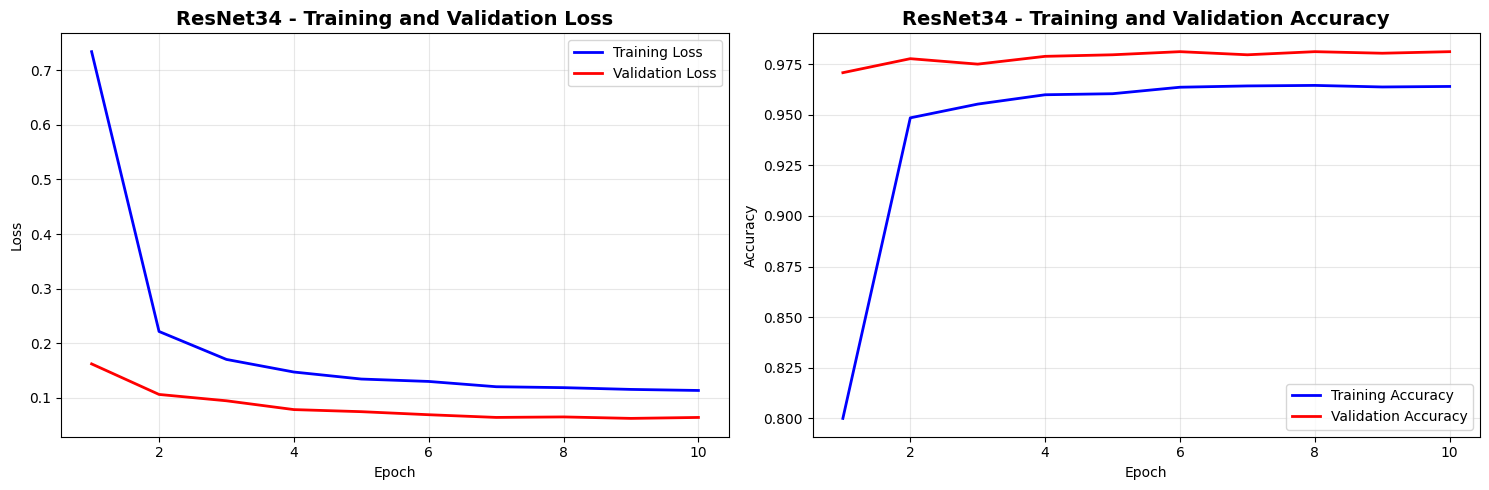

In [9]:
# 5. Plot the loss and accuracy curves.

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(
    range(1, len(train_losses_resnet34) + 1),
    train_losses_resnet34,
    "b-",
    label="Training Loss",
    linewidth=2,
)
plt.plot(
    range(1, len(val_losses_resnet34) + 1),
    val_losses_resnet34,
    "r-",
    label="Validation Loss",
    linewidth=2,
)
plt.title("ResNet34 - Training and Validation Loss", fontsize=14, fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(
    range(1, len(train_accs_resnet34) + 1),
    train_accs_resnet34,
    "b-",
    label="Training Accuracy",
    linewidth=2,
)
plt.plot(
    range(1, len(val_accs_resnet34) + 1),
    val_accs_resnet34,
    "r-",
    label="Validation Accuracy",
    linewidth=2,
)
plt.title("ResNet34 - Training and Validation Accuracy", fontsize=14, fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Step 3 Train the student model (ResNet18)

1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.


In [10]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [11]:
# 1. Set hyperparameters for the distillation process.

MAX_EPOCH = 40
INIT_LR = 0.001
BATCH_SIZE = 64
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")

TEMPERATURE = 2
LOSS_RATIO = 0.25

In [12]:
# 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.

resnet18 = torchvision.models.resnet18(weights=None)
resnet18.fc = nn.Sequential(
    nn.Dropout(0.5), nn.Linear(resnet18.fc.in_features, num_classes)
)

resnet18 = resnet18.to(device)

In [13]:
# 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet34 = torchvision.models.resnet34(weights=None)
resnet34.fc = nn.Sequential(
    nn.Dropout(0.5), nn.Linear(resnet34.fc.in_features, num_classes)
)
resnet34.load_state_dict(torch.load("../models/resnet34_checkpoint.pkl"))
resnet34 = resnet34.to(device)
resnet34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# 4. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet18.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

In [15]:
# 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.
#       Details can be fund in https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html.

train_accs_resnet18, train_losses_resnet18, val_accs_resnet18, val_losses_resnet18 = (
    [],
    [],
    [],
    [],
)

best_val_acc = 0.0
best_val_loss = float("inf")

train_dataset = TensorDataset(tensor_train, labels_train_index)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)

val_dataset = TensorDataset(tensor_val, labels_val_index)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

ce_loss = nn.CrossEntropyLoss()

print(f"Starting knowledge distillation training for {MAX_EPOCH} epochs...")
print(f"Temperature: {TEMPERATURE}")
print(f"Loss ratio (KD:CE): {LOSS_RATIO}:{1-LOSS_RATIO}")

resnet34.eval()
resnet18.train()

for epoch in range(MAX_EPOCH):
    print("-" * 60)
    print(f"Epoch {epoch+1}/{MAX_EPOCH}")
    print("-" * 20)
    resnet18.train()
    running_loss = 0.0
    train_corrects = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.no_grad():
            teacher_logits = resnet34(inputs)

        student_logits = resnet18(inputs)

        soft_targets = F.softmax(teacher_logits / TEMPERATURE, dim=-1)
        soft_prob = F.log_softmax(student_logits / TEMPERATURE, dim=-1)

        soft_targets_loss = (
            torch.sum(soft_targets * (soft_targets.log() - soft_prob))
            / soft_prob.size()[0]
            * (TEMPERATURE**2)
        )

        label_loss = ce_loss(student_logits, labels)

        loss = LOSS_RATIO * soft_targets_loss + (1 - LOSS_RATIO) * label_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(student_logits, 1)
        train_corrects += torch.sum(preds == labels)

    epoch_train_loss = running_loss / len(tensor_train)
    epoch_train_acc = train_corrects / len(tensor_train)

    train_losses_resnet18.append(epoch_train_loss)
    train_accs_resnet18.append(epoch_train_acc.item())

    resnet18.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            student_logits = resnet18(inputs)

            loss = ce_loss(student_logits, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(student_logits, 1)
            val_corrects += torch.sum(preds == labels)

    epoch_val_loss = val_loss / len(tensor_val)
    epoch_val_acc = val_corrects / len(tensor_val)

    val_losses_resnet18.append(epoch_val_loss)
    val_accs_resnet18.append(epoch_val_acc.item())

    print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    print(f"Val   Loss: {epoch_val_loss:.4f}, Val   Acc: {epoch_val_acc:.4f}")

    scheduler.step()

    is_better = False
    if epoch_val_acc > best_val_acc:
        is_better = True
    elif epoch_val_acc == best_val_acc and epoch_val_loss < best_val_loss:
        is_better = True

    if is_better:
        best_val_acc = epoch_val_acc
        best_val_loss = epoch_val_loss
        torch.save(resnet18.state_dict(), "../models/resnet18_checkpoint.pkl")
        print(
            f"Best model saved! Val Acc: {epoch_val_acc:.4f}, Val Loss: {epoch_val_loss:.4f}"
        )

    print()

print("Knowledge distillation training completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting knowledge distillation training for 40 epochs...
Temperature: 2
Loss ratio (KD:CE): 0.25:0.75
------------------------------------------------------------
Epoch 1/40
--------------------
Train Loss: 2.3626, Train Acc: 0.4865
Val   Loss: 1.3308, Val   Acc: 0.5662
✅ Best model saved! Val Acc: 0.5662, Val Loss: 1.3308

------------------------------------------------------------
Epoch 2/40
--------------------
Train Loss: 1.8140, Train Acc: 0.6218
Val   Loss: 1.6752, Val   Acc: 0.5604

------------------------------------------------------------
Epoch 3/40
--------------------
Train Loss: 1.5882, Train Acc: 0.6737
Val   Loss: 0.9677, Val   Acc: 0.7169
✅ Best model saved! Val Acc: 0.7169, Val Loss: 0.9677

------------------------------------------------------------
Epoch 4/40
--------------------
Train Loss: 1.3835, Train Acc: 0.7226
Val   Loss: 0.8694, Val   Acc: 0.7281
✅ Best model saved! Val Acc: 0.7281, Val Loss: 0.8694

-------------------------------------------------------

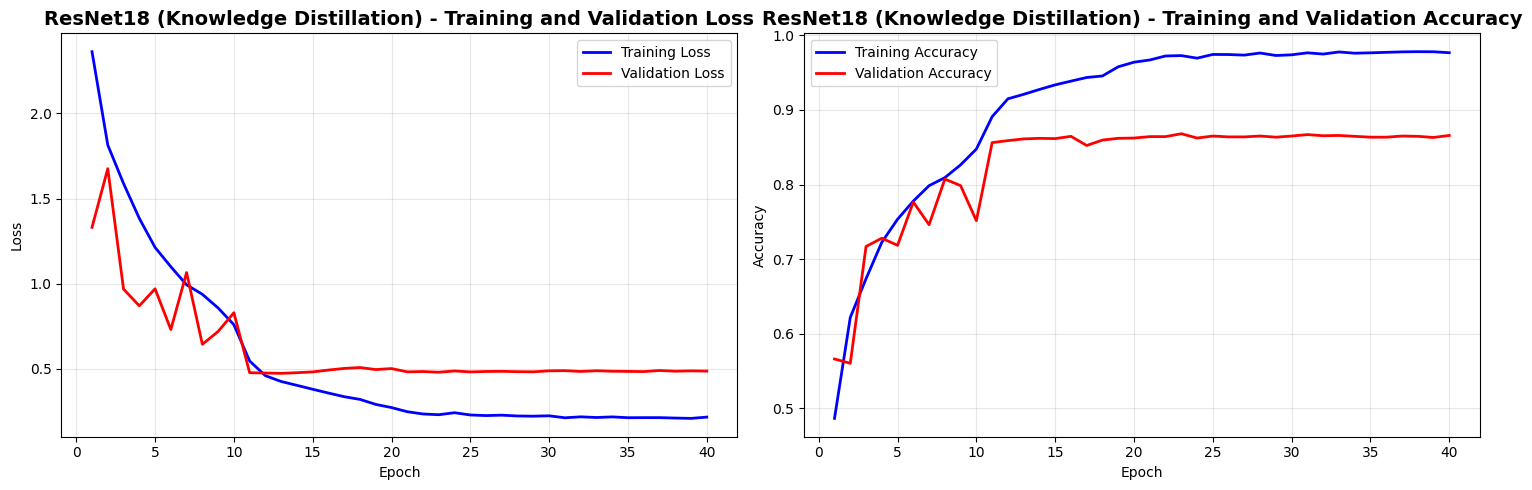

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(
    range(1, len(train_losses_resnet18) + 1),
    train_losses_resnet18,
    "b-",
    label="Training Loss",
    linewidth=2,
)
plt.plot(
    range(1, len(val_losses_resnet18) + 1),
    val_losses_resnet18,
    "r-",
    label="Validation Loss",
    linewidth=2,
)
plt.title(
    "ResNet18 (Knowledge Distillation) - Training and Validation Loss",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(
    range(1, len(train_accs_resnet18) + 1),
    train_accs_resnet18,
    "b-",
    label="Training Accuracy",
    linewidth=2,
)
plt.plot(
    range(1, len(val_accs_resnet18) + 1),
    val_accs_resnet18,
    "r-",
    label="Validation Accuracy",
    linewidth=2,
)
plt.title(
    "ResNet18 (Knowledge Distillation) - Training and Validation Accuracy",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Step 4 Predict labels in the testing set

1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.


In [17]:
# 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.
device = torch.device("mps")
resnet18 = torchvision.models.resnet18(weights=None)
resnet18.fc = nn.Sequential(
    nn.Dropout(0.5), nn.Linear(resnet18.fc.in_features, num_classes)
)
resnet18.load_state_dict(torch.load("../models/resnet18_checkpoint.pkl"))
resnet18 = resnet18.to(device)
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# 2. Do prediction using the images in the testing set.
BATCH_SIZE = 64

predictions = []

print(f"Starting prediction on {len(tensor_test)} test images...")
print(f"Test tensor shape: {tensor_test.shape}")

test_dataset = TensorDataset(tensor_test)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

resnet18.eval()
with torch.no_grad():
    for batch_idx, (inputs,) in enumerate(test_loader):
        inputs = inputs.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        batch_predictions = preds.cpu().tolist()
        predictions.extend(batch_predictions)

print(f"Prediction completed! Total predictions: {len(predictions)}")

Starting prediction on 2600 test images...
Test tensor shape: torch.Size([2600, 3, 224, 224])
Prediction completed! Total predictions: 2600


In [19]:
# 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

index_to_label = torch.load("../data_preprocessed/index_to_label.pt")
filenames = [f"{i}.jpg" for i in range(len(predictions))]
predicted_labels = [index_to_label[pred_idx] for pred_idx in predictions]

submission_df = pd.DataFrame({"file_name": filenames, "label": predicted_labels})
submission_df.to_csv("../submission.csv", index=False)